In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/1_Environment_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Run and restart runtime
!apt-get install swig build-essential python-dev python3-dev
!pip install pygame==2.1.0
!pip install box2d-py==2.3.5 
!pip install gym[Box2d,atari,accept-rom-license]==0.23.1
!pip install pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2
!pip install imageio==2.4.1
!git clone https://github.com/racousin/rl_introduction.git
from rl_introduction.rl_introduction.render_colab import gym_render

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Note, selecting 'python-dev-is-python2' instead of 'python-dev'
python3-dev is already the newest version (3.8.2-0ubuntu2).
python3-dev set to manually installed.
build-essential is already the newest version (12.8ubuntu1.1).
The following additional packages will be installed:
  libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  python-is-python2 python2 python2-dev python2-minimal python2.7-dev swig4.0
Suggested packages:
  python2-doc python-tk swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  libpython2-dev libpython2-stdlib libpython2.7 libpython2.7-dev
  python-dev-is-python2 python-is-python2 python2 python2-dev python2-minimal
  python2.7-dev swig swig4.0
0 upgraded, 12 newly installed, 0 to remove and 23 not upgraded.
Need to get 4,956 kB of archives.
After this operation, 23.4 MB of additional disk space will be used.


### Objective
Here we present the type of problem that RL is addressing. And the main interactions between the environment and the agents.

**Complete the TODO steps! Good luck!**

In [3]:
import seaborn as sns
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import gym
from time import time,sleep
sns.set_style("darkgrid")

# 1_Environment_and_Agent

The environment encapsules the `transition model` ($\mathbb{P}(S_{t+1},R_{t+1}|S_t,A_t)$).

Science of environments is complex, particulary for real problems simulation (e.g for autonomous vehicules).

It is easiest when then environment is already completly defined (e.g Videos Games).

### Minimal environment class
The main part of a virtual environment is the `step function`. It takes the <b>action</b> and it returns a new <b>state</b>, the associated <b>reward</b>, a boolean (<b>done</b>) to indicate if it is a final step, and eventually some <b>info</b>.

In [ ]:
# Environment class
class Env:
    def __init__(self):
        self.state = 0
        self.done = False
        
    def step(self, action):
        ...
        return state, reward, done, info
        
        
    def reset(self):
        self.__init__()
        return self.state

### Exemple of environment

This environment generates a random state number. If the action is the same parity, reward is $1$, otherwise reward is $-1$

**States:** $S = \{0,1\}$

**Actions:** $A = \mathbb{N^+}$

**Transition model:** $P_{ss'}^a = \mathbb{P} [S_{t+1} = s' \vert S_t = s, A_t = a]$

$\forall a \in A, \forall s,s' \in S : P_{ss'}^a = 0.5$

**Reward function:**
$R(s, a) = \mathbb{E} [R_{t+1} \vert S_t = s, A_t = a]$, $\textit{deterministic, in this case}$

$\forall a \in 2 \mathbb{N} : R(0,a) = 1$

$\forall a \in 2 \mathbb{N} + 1: R(1,a) = 1$

$\forall a \in 2 \mathbb{N} : R(1,a) = -1$

$\forall a \in 2 \mathbb{N} + 1 : R(0,a) = -1$

In [ ]:
#TODO: Complete the Env_odd_even step
# Exemple of environment
class Env_odd_even(Env):
    def step(self, action):
        #complete here
        return self.state, reward, self.done, {}

In [ ]:
#Done: Complete the Env_odd_even step
# Exemple of environment
class Env_odd_even(Env):
    def step(self, action):
        if (action % 2 == 0 and self.state % 2 == 0) or (action % 2 == 1 and self.state % 2 == 1):
            reward = 1
        else:
            reward = -1
        self.state = np.random.randint(2)
        return self.state, reward, self.done, {}

In [ ]:
# Instantiation
env = Env_odd_even()

In [ ]:
# Try to interact with the environment
action = 17
state, reward, _, _ = env.step(action)
print(f"action: {action}, reward: {reward}, state: {state}")

action: 17, reward: -1, state: 1


### Minimal agent class

The `act function` return an <b>action</b> for a <b>state</b> according to the agent policy.
A smart agent may learn and update its policy.

In [27]:
# Agent class
class Agent:
    def __init__(self, env):
        self.env = env
    def act(self, state):
        return action
    def train():
        pass

### Random agent
It acts randomly. It is useful as lower bound for benchmark.

**Policy:** $a_t \sim \pi(\cdot | s_t) \to \mathbb{P}(a_t|s_t)$

$\forall s \in S : \mathbb{P}(a=0|s) = \mathbb{P}(a=1|s) = 0.5$

In [ ]:
# Random agent
#TODO: Complete the Random Agent
class MyRandomAgent(Agent):
    def act(self, state):
        #complete here
        return action

In [ ]:
# Random agent
#Done: Complete the Random Agent
class MyRandomAgent(Agent):
    def act(self, state):
        action = np.random.randint(2)
        return action

In [ ]:
# Instantiation
agent = MyRandomAgent(env)
# Try to interact with the agent
state = 1
action = agent.act(state)
print(f"action: {action}")

action: 0


### Super agent
When we know the best policy. It serves as higher bound for the benchmark and it allows to compute the regret.


**Policy:**

$\mathbb{P}(a=0|s=0) = \mathbb{P}(a=1|s=1) = 1$

$\mathbb{P}(a=1|s=0) = \mathbb{P}(a=0|s=1) = 0$

In [ ]:
# Optimal agent
#TODO: Complete the Super Agent
class MySuperAgent(Agent):
    def act(self, state):
      #complete here
        return action

In [ ]:
# Optimal agent
#Done: Complete the Super Agent
class MySuperAgent(Agent):
    def act(self, state):
        if state % 2 == 0:
            action = 0
        else:
            action = 1
        return action

In [ ]:
# Instantiation
agent = MySuperAgent(env)
# Try to interact with the agent
state = 1
action = agent.act(state)
print(f"action: {action}")

action: 1


### Minimal agent and environement example

In [ ]:
# Instantiation
env = Env_odd_even()
my_random_agent = MyRandomAgent(env)

In [ ]:
previous_state = env.reset() #initial state

In [ ]:
# Try some 
action = my_random_agent.act(previous_state)
state, reward, _, _ = env.step(action)
print(f"previous_state: {previous_state}, action: {action}, reward: {reward}, state: {state}")
previous_state = state

previous_state: 0, action: 0, reward: 1, state: 0


### Compute rewards in agent-environment interaction 

Now, we want to compare the performance of our agents. The empirical way to do it is to observe the cumulative reward (following the agent policy).

**Generate trajectory:** $\tau$ following the policy $\pi$ $S_1,A_1,R_2,…,S_T$ to compute an estimation of Return $G_t = \sum_{k=0}^{T-t-1} R_{t+k+1}$

In [ ]:
#TODO: Compute an estimation of Return (ie cumulative reward)
def run_experiment(env, agent, nb_step):
    state = env.reset()
    for i in range(nb_step):
      #complete here
    return cumulative_reward, []

IndentationError: ignored

In [ ]:
#DONE: Compute an estimation of Return (ie cumulative reward)
def run_experiment(env, agent, nb_step):
    rewards = np.zeros(nb_step)
    state = env.reset()
    for i in range(nb_step):
        action = agent.act(state) #agent chooses action
        state, reward, done, info = env.step(action) # feedback of environment
        rewards[i] = reward
    return sum(rewards), rewards

In [ ]:
nb_step = 100

cumulative_reward: 6.0


Text(0.5, 1.0, 'cumulative reward - random_agent')

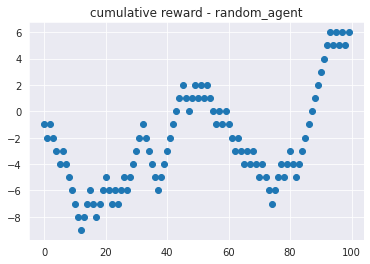

In [ ]:
env = Env_odd_even()
my_random_agent = MyRandomAgent(env)
cumulative_reward, rewards = run_experiment(env, my_random_agent, nb_step)
print(f"cumulative_reward: {cumulative_reward}")
plt.plot(rewards.cumsum(), 'o')
plt.title('cumulative reward - random_agent')

cumulative_reward: 100.0


Text(0.5, 1.0, 'cumulative reward - super_agent')

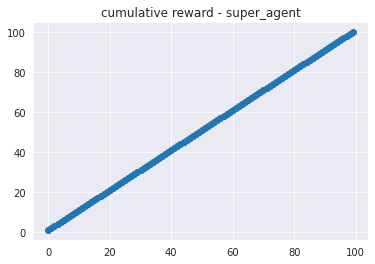

In [ ]:
env = Env_odd_even()
my_super_agent = MySuperAgent(env)
cumulative_reward, rewards = run_experiment(env, my_super_agent, nb_step)
print(f"cumulative_reward: {cumulative_reward}")
plt.plot(rewards.cumsum(),'o')
plt.title('cumulative reward - super_agent')

Remark: We can calculate **the expected return:** $ J(\pi) = E_{\tau\sim \pi}[{G(\tau)}] = \int_{\tau} \mathbb{P}(\tau|\pi) G(\tau)$ using the transition model  $ \mathbb{P}(\tau|\pi) = \rho_0 (s_0) \prod_{t=0}^{T-1} P(s_{t+1} | s_t, a_t) \pi(a_t | s_t)$

For the random policy $J(\pi) = 0$ and regret is T

For the optimal policy $J(\pi^*) = T$ and regret is 0

### Exemple of environment with episode end
We will consider a "smarter" environment that avoid cheaters. **Same as Env_odd_even** env, it will generate a random state number. If the action is the same parity, reward is $1$, otherwise reward is $-1$. **But, now, if the agent wins 3 consectives times, the episode ends**. **And in all cases, after 500 iterations, episode ends.**

In [ ]:
#TODO update Env_odd_even to build the new env logic 
class Env_odd_even2(Env):
    def __init__(self):
        #complete here
    def step(self, action):
        #complete here
        return self.state, reward, self.done, {}

IndentationError: ignored

In [ ]:
#Done update Env_odd_even to build the new env logic 
class Env_odd_even2(Env):
    def __init__(self):
        self.state = 0
        self.nb_consecutive_win = 0
        self.limit_game = 500
        self.done = False
    def step(self, action):
        if (action % 2 == 0 and self.state % 2 == 0) or (action % 2 == 1 and self.state % 2 == 1):
            self.nb_consecutive_win += 1
            reward = 1
        else:
            self.nb_consecutive_win = 0
            reward = -1
        self.state = np.random.randint(2)
        if self.nb_consecutive_win == 3 or self.limit_game == 0:
            self.done = True
        self.limit_game -= 1
        return self.state, reward, self.done, {}

Now, we observe the cumulative reward through trajectories (following the agent policy).

In [53]:
def run_experiment_episode(env, agent, nb_episode):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset() 
        done = False
        rews = []
        while done is False:
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

Text(0.5, 1.0, 'cumulative reward per episode - random_agent')

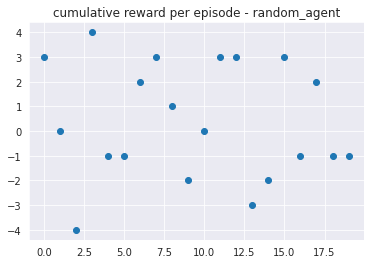

In [ ]:
env = Env_odd_even2()
rewards = run_experiment_episode(env, my_random_agent, 20)
plt.plot(rewards, 'o')
plt.title('cumulative reward per episode - random_agent')

Text(0.5, 1.0, 'cumulative reward per episode - super_agent')

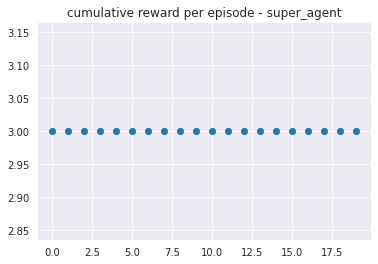

In [ ]:
env = Env_odd_even2()
rewards = run_experiment_episode(env, my_super_agent, 20)
plt.plot(rewards,'o')
plt.title('cumulative reward per episode - super_agent')

The super agent is far to be the best for the new environment

# ENVIRONMENT FROM OPENAI
https://gymnasium.farama.org/

## Discrete state action environment

### FrozenLake

<img src="https://github.com/racousin/rl_introduction/blob/master/notebooks/images/FrozenLake.png?raw=1">

In [6]:
env = gym.make('FrozenLake-v1')
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
env.reset()
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(4)
description observation space: Discrete(16)
run some random iteration:

action: 
2
state: 
1
reward: 
0.0

action: 
0
state: 
5
reward: 
0.0

action: 
1
state: 
5
reward: 
0


In [7]:
gyn_render(env_name='FrozenLake-v1', directory='./video', agent = 'random', slow_coeff=10)

  result = np.fromstring(s, dtype='uint8')



## Discrete action continuous space environment

### CartPole
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
<img src="https://github.com/racousin/rl_introduction/blob/master/notebooks/images/CartPole-v1.png?raw=1">
observations: position of cart, velocity of cart, angle of pole, rotation rate of pole

In [8]:
env = gym.make('CartPole-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(2)
description observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
run some random iteration:

action: 
1
state: 
[ 0.01717957  0.15860674 -0.00681841 -0.33076385]
reward: 
1.0

action: 
1
state: 
[ 0.02035171  0.3538251  -0.01343369 -0.62558913]
reward: 
1.0

action: 
0
state: 
[ 0.02742821  0.15889321 -0.02594547 -0.3371671 ]
reward: 
1.0


Most of the environments are provide with a render:

In [9]:
gyn_render(env_name='CartPole-v0', directory='./video', agent = 'random', slow_coeff=10)

## Continuous action-space environment

### MountainCarContinuous
An underpowered car must climb a one-dimensional hill to reach a target. Unlike MountainCar v0, the action (engine force applied) is allowed to be a continuous value.

The target is on top of a hill on the right-hand side of the car. If the car reaches it or goes beyond, the episode terminates.

On the left-hand side, there is another hill. Climbing this hill can be used to gain potential energy and accelerate towards the target. On top of this second hill, the car cannot go further than a position equal to -1, as if there was a wall. Hitting this limit does not generate a penalty (it might in a more challenging version).
<img src="https://github.com/racousin/rl_introduction/blob/master/notebooks/images/MountainCarContinuous-v0.png?raw=1">

In [10]:
env = gym.make('MountainCarContinuous-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Box(-1.0, 1.0, (1,), float32)
description observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
run some random iteration:

action: 
[-0.54017615]
state: 
[-5.660937e-01 -4.961058e-04]
reward: 
-0.029179027646756596

action: 
[-0.43089885]
state: 
[-0.5669183 -0.0008246]
reward: 
-0.01856738147910484

action: 
[0.2282463]
state: 
[-5.6707656e-01 -1.5825266e-04]
reward: 
-0.005209637410852341


In [13]:
gyn_render(env_name='MountainCarContinuous-v0', directory='./video', agent = 'random', slow_coeff=1, max_step=50)

  result = np.fromstring(s, dtype='uint8')



### LunarLanderContinuous
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Action is two real values vector from -1 to +1. First controls main engine, -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power. Second value -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off.
<img src="https://github.com/racousin/rl_introduction/blob/master/notebooks/images/LunarLanderContinuous-v2.png?raw=1">

In [14]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
print()
for _ in range(3):
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Box(-1.0, 1.0, (2,), float32)
description observation space: Box(-inf, inf, (8,), float32)
run some random iteration:

action: 
[-0.54859686 -0.48841643]
state: 
[ 0.00265322  1.420038    0.1341724   0.18977088 -0.00303418 -0.03007769
  0.          0.        ]
reward: 
1.5733715269500124
action: 
[-0.5601251   0.11795449]
state: 
[ 0.00397968  1.4237086   0.13417713  0.16313173 -0.00453712 -0.03006182
  0.          0.        ]
reward: 
1.6011433573237923
action: 
[0.84935004 0.98473275]
state: 
[ 0.0054493   1.4276212   0.15033267  0.1738854  -0.00787955 -0.06685483
  0.          0.        ]
reward: 
-2.8966649198652714


In [16]:
gyn_render(env_name='LunarLanderContinuous-v2', directory='./video', agent = 'random', slow_coeff=1)

## High space dimension environment

### Atari games


In [17]:
env = gym.make('Pong-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
print()
for _ in range(3):
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(6)
description observation space: Box(0, 255, (210, 160, 3), uint8)
run some random iteration:

action: 
5
state: 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 ...

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]]
reward: 
0.0
action: 
3
state: 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17

In [24]:
gyn_render(env_name='Pong-v0', directory='./video', agent = 'random', slow_coeff=1)

# Evaluate Random agent in open ai gym

In [ ]:
env = gym.make('Pong-v0')

In [30]:
class RandomAgent(Agent):
    def act(self, state):
            return self.env.action_space.sample()

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

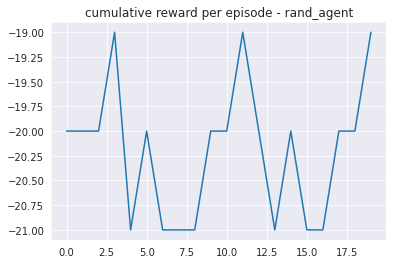

In [ ]:
rand_agent = RandomAgent(env)
rewards = run_experiment_episode(env, rand_agent, 20)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

### Build your CartPole euristic agent

In [46]:
env = gym.make('CartPole-v0')

In [47]:
#TODO: Create a cartPole agent that is better than Random:
class MyCartPoleAgent(Agent):
    def __init__(self, env):
        super().__init__(env)
    def act(self, state):
        #Complete
        return action

In [49]:
#Done: Create a cartPole agent that is better than Random:
class MyCartPoleAgent(Agent):
    def __init__(self, env, params=[-0.9,-0.1,0,0,-0.9, 0, 0.9]):
        super().__init__(env)
        self.params = params
    def act(self, state):
        if state[0] > self.params[0] and state[2] > self.params[1] and state[3] <= self.params[2]:
            action = 0
        elif state[3] > self.params[4] and state[1] >= self.params[5] and state[1] <= self.params[6]:
            action = 1
        else:
            action = 1
        return action
        

total reward random agent: 2191.0
total reward manual agent: 16686.0


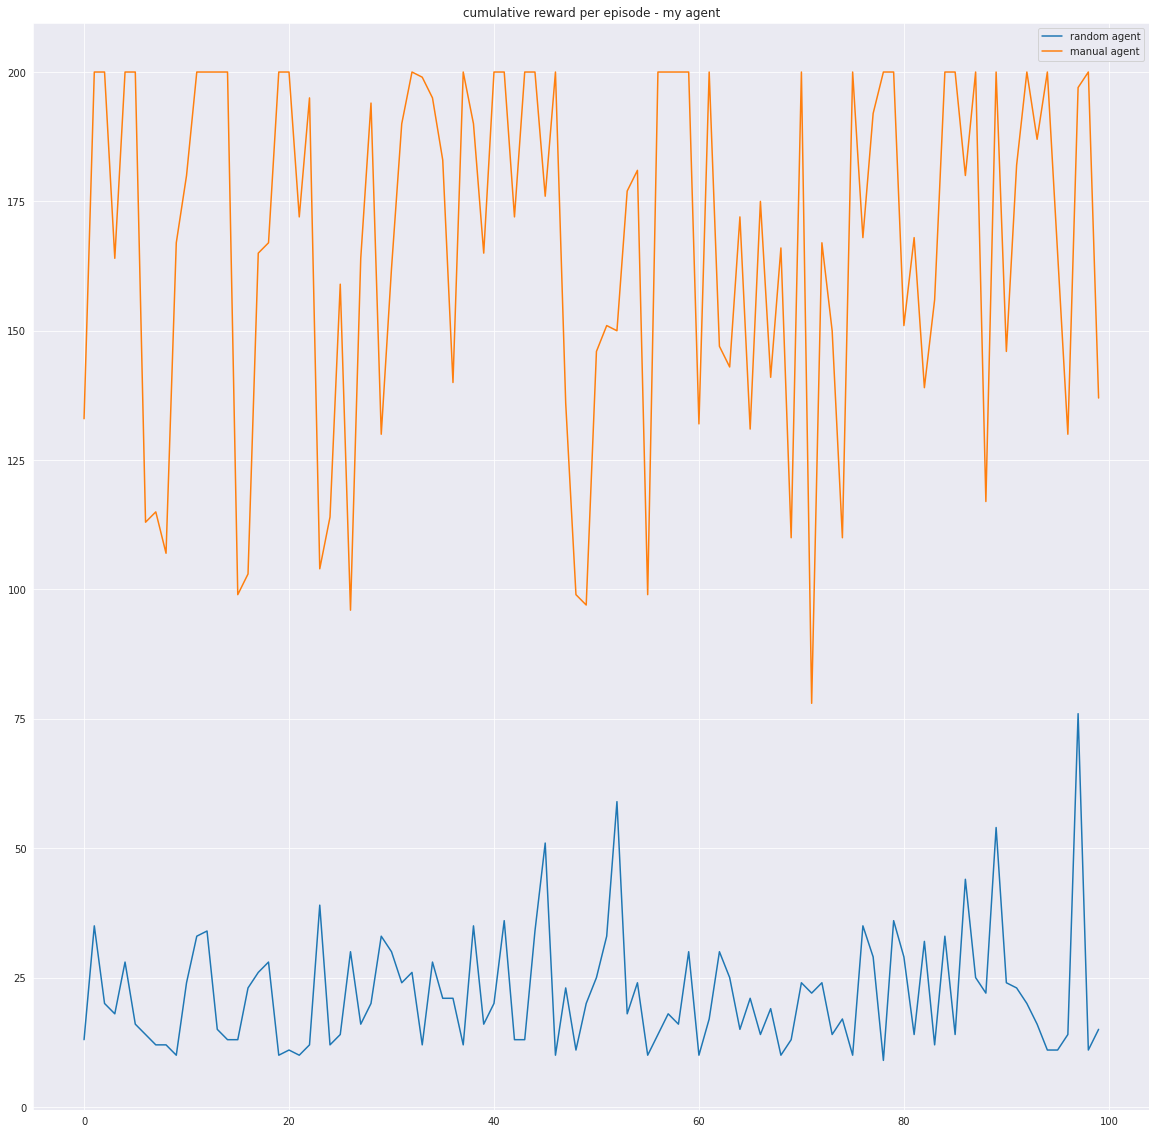

In [54]:
nb_experience = 100
plt.figure(figsize=(20,20))
rand_agent = RandomAgent(env)
rewards = run_experiment_episode(env, rand_agent, nb_experience)
print(f'total reward random agent: {sum(rewards)}')
plt.plot(rewards, label=f'random agent')
rand_agent = MyCartPoleAgent(env)
rewards = run_experiment_episode(env, rand_agent, nb_experience)
print(f'total reward manual agent: {sum(rewards)}')
plt.plot(rewards, label=f'manual agent')
plt.title('cumulative reward per episode - my agent')
plt.legend()